In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#load in cleaned and transformed data file
df = pd.read_csv("Data\\Export\\central_dem_grades_clean.csv")

#convert date of birth column from str to datetime type, extract year, drop date column
df['Date_of_Birth'] = pd.to_datetime(df['Date_of_Birth'], format = '%Y-%m-%d')
df['Birth_Year'] = df['Date_of_Birth'].dt.year
df = df.drop('Date_of_Birth', axis = 1)

#show first 5 rows
#df.head()


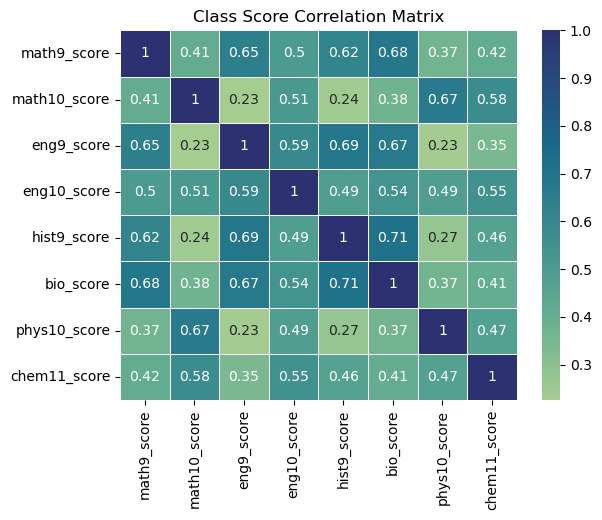

In [2]:
import seaborn as sns
core_courses = ['math9_score', 'math10_score', 'eng9_score', 'eng10_score', 
                'hist9_score', 'bio_score', 'phys10_score', 'chem11_score']

corr_matrix = df[core_courses].corr()
#corr_matrix['chem11_score']

fig, ax = plt.subplots()
sns.heatmap(corr_matrix, annot=True, cmap = "crest", linewidths= 0.5)
ax.set(title= 'Class Score Correlation Matrix')

plt.show()

In [3]:
#asscociation rule mining for categorical data and Chem Grades
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth, association_rules

all_categories = ['ID', 'chem11', 'Gender', 'Counselor', 'ELL_Status', 
                  'Double_Math', 'FRPL_Status', 'Home_Language', 
                  'Race_Ethnicity', 'Special_Education_Status']

#replace coded values with text (must be string for encoder to work) for each column
df_rules = df[all_categories].set_index('ID')
df_rules['chem11'] = df_rules['chem11'].replace({0: 'No Chem', 1: "Chem 1", 2: "Chem 1 Hon", 5: "Chem 1 Bi"})
df_rules['Gender'] = df_rules['Gender'].replace({0: 'Female', 1: "Male"})
df_rules['Counselor'] = df_rules['Counselor'].astype(str)
df_rules['ELL_Status'] = df_rules['ELL_Status'].replace({False: 'NonELL', True: "ELL"})
df_rules['Double_Math'] = df_rules['Double_Math'].replace({0: 'Math1', 1: "Math2"})
df_rules['FRPL_Status'] = df_rules['FRPL_Status'].replace({1: 'Paid Lunch', 2: "Reduced Lunch", 3: "Free Lunch"})
df_rules['Home_Language'] = df_rules['Home_Language'].replace({0: 'English', 1: "Spanish"})
df_rules['Home_Language'] = df_rules['Home_Language'].replace([2, 3, 4, 5, 6], "Other")
df_rules['Race_Ethnicity'] = df_rules['Race_Ethnicity'].replace({5: 'White', 4: "Asian", 3: "Hispanic", 2: "Black", 1: "Multi", 0: "Native"})
df_rules['Special_Education_Status'] = df_rules['Special_Education_Status'].replace({False: 'NoSPED', True: "SPED"})

#convert df to list of lists
list_rules = df_rules.values.tolist()

te = TransactionEncoder()
te_ary = te.fit(list_rules).transform(list_rules)
df_rules2 = pd.DataFrame(te_ary, columns=te.columns_)

#create df of most common occuring demographic info
frequent_itemsets = fpgrowth(df_rules2, min_support=0.05, use_colnames=True)

#create rules based on lift metric
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.20)
#rules.sort_values(['lift'], ascending = False)

#extract rules for Chem1
rules[rules["consequents"].apply(lambda x: 'Chem 1' in str(x))].sort_values(['lift'], ascending = False).head()


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
20869,"(NoSPED, Paid Lunch)","(NonELL, Hispanic, Chem 1)",0.219340,0.112028,0.050708,0.231183,2.063611,0.026135,1.154984,0.660226
20857,"(NonELL, NoSPED, Hispanic, Paid Lunch)",(Chem 1),0.133255,0.188679,0.050708,0.380531,2.016814,0.025565,1.309704,0.581680
20902,"(NonELL, NoSPED, Math1, Paid Lunch)",(Chem 1),0.168632,0.188679,0.062500,0.370629,1.964336,0.030683,1.289099,0.590499
20861,"(NonELL, NoSPED, Paid Lunch)","(Hispanic, Chem 1)",0.192217,0.134434,0.050708,0.263804,1.962329,0.024867,1.175727,0.607096
20907,"(NoSPED, Math1, Paid Lunch)","(NonELL, Chem 1)",0.195755,0.166274,0.062500,0.319277,1.920191,0.029951,1.224766,0.595861


In [4]:
#asscociation rule mining for categorical data and Chem Grades
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth

all_categories = ['ID', 'chem11', 'Counselor']

#replace coded values with text (must be string for encoder to work) for each column
df_rules = df[all_categories].set_index('ID')
df_rules['chem11'] = df_rules['chem11'].replace({0: 'No Chem', 1: "Chem 1", 2: "Chem 1 Hon", 5: "Chem 1 Bi"})
df_rules['Counselor'] = df_rules['Counselor'].astype(str)


#convert df to list of lists
list_rules = df_rules.values.tolist()

te = TransactionEncoder()
te_ary = te.fit(list_rules).transform(list_rules)
df_rules2 = pd.DataFrame(te_ary, columns=te.columns_)

#create df of most common occuring demographic info
frequent_itemsets = fpgrowth(df_rules2, min_support=0.05, use_colnames=True)

#create rules based on lift metric
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.20)
rules.sort_values(['lift'], ascending = False)

#extract rules for Chem1
#rules[rules["consequents"].apply(lambda x: 'Chem 1' in str(x))].sort_values(['lift'], ascending = False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
2,(34),(No Chem),0.095519,0.741745,0.081368,0.851852,1.148443,0.010517,1.743219,0.142906
0,(19),(No Chem),0.120283,0.741745,0.100236,0.833333,1.123476,0.011016,1.549528,0.124933
3,(37),(No Chem),0.080189,0.741745,0.063679,0.794118,1.070607,0.004200,1.254380,0.071700
5,(22),(No Chem),0.101415,0.741745,0.077830,0.767442,1.034643,0.002606,1.110495,0.037262
1,(10),(No Chem),0.095519,0.741745,0.073113,0.765432,1.031934,0.002263,1.100981,0.034214
8,(28),(No Chem),0.074292,0.741745,0.055425,0.746032,1.005779,0.000318,1.016878,0.006207
7,(31),(No Chem),0.130896,0.741745,0.091981,0.702703,0.947364,-0.005111,0.868675,-0.060087
4,(25),(No Chem),0.121462,0.741745,0.082547,0.679612,0.916233,-0.007547,0.806068,-0.094256
6,(13),(No Chem),0.095519,0.741745,0.063679,0.666667,0.898781,-0.007171,0.774764,-0.110725
9,(16),(No Chem),0.084906,0.741745,0.051887,0.611111,0.823883,-0.011092,0.664084,-0.189364


In [6]:
#dimensionality reduction for ML 
#Factor analysis of mixed data https://pypi.org/project/prince/0.7.1/
from prince import FAMD

df_ML= df

df_ML['Chem11_grade'] = pd.cut(x=df_ML['chem11_score'], 
                                     bins=[0, 59.5, 69.5, 79.5, 89.5, 100],
                                     labels = ['F', 'D', 'C', 'B', 'A'])

df_ML_train = df_ML[df_ML['chem11']>0]
df_ML_test = df_ML[df_ML['chem11'] == 0]

#reset index to id 
df_ML_train = df_ML_train.set_index(['ID'])
df_ML_test = df_ML_test.set_index(['ID'])

#extract labels and drop nan
df_ML_train = df_ML_train.dropna()
df_ML_labels = df_ML_train[['chem11', 'chem11_score', 'Chem11_grade']]
df_ML_train = df_ML_train.drop(['chem11', 'chem11_score', 'Chem11_grade'], axis = 1)


df_ML_test = df_ML_test.drop(['chem11', 'chem11_score', 'Chem11_grade'], axis = 1)
df_ML_test = df_ML_test.dropna()

C:\Users\Michael\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:797: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if dtype_orig is not None and dtype_orig in dtype:


[Text(0.5, 1.0, 'Chem scores based on attributes'),
 Text(0.5, 0, 'Factor Analysis Score'),
 Text(0, 0.5, 'Chem11 Score')]

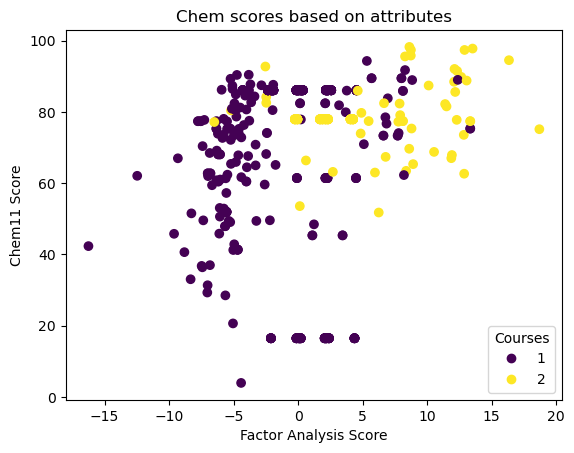

In [7]:
#dimensionality reduction to plot chem scores vs other factors

#set up FAMD method
famd_1D = FAMD(n_components=1,n_iter=3,copy=True,check_input=True,engine='sklearn', random_state=42)

#use function to reduce dimensionality
famd_1D =famd_1D.fit(df_ML_train)
df_ML_train_reduced_1D = famd_1D.row_coordinates(df_ML_train)

#join reduced datafram with labeled data based on ID
df_ML_train_reduced_1D_labels = df_ML_train_reduced_1D.join(df_ML_labels[['chem11', 'chem11_score']]).reset_index()

#create graph of reduced component and chem score with colors for courses
x = df_ML_train_reduced_1D_labels[0]
y = df_ML_train_reduced_1D_labels['chem11_score']
c = df_ML_train_reduced_1D_labels['chem11']

fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=c)

#create legend
legend = ax.legend(*scatter.legend_elements(),
                   title = 'Courses', 
                   loc = 'lower right')
ax.set(title= "Chem scores based on attributes", xlabel = 'Factor Analysis Score',
     ylabel = 'Chem11 Score')


C:\Users\Michael\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:797: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if dtype_orig is not None and dtype_orig in dtype:
c:\Users\Michael\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\Michael\anaconda3\lib\site-packages\seaborn\utils.py:387: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles


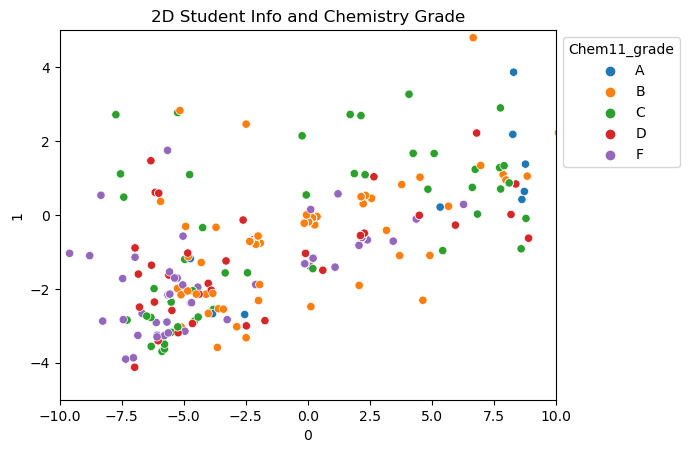

In [9]:
#set up FAMD method
famd_2D = FAMD(n_components=2,n_iter=3,copy=True,check_input=True,engine='sklearn',random_state=42)
#famd2_2D = FAMD(n_components=2,n_iter=3,copy=True,check_input=True,engine='sklearn',random_state=42)

#reduce dimensions for training set
famd_2D =famd_2D.fit(df_ML_train)
df_ML_train_reduced_2D = famd_2D.row_coordinates(df_ML_train)

#join reduced data with labels
df_ML_train_reduced_2D_labels = df_ML_train_reduced_2D.join(df_ML_labels['Chem11_grade']).reset_index()

#reduce dimensions for testing set
#famd2_2D =famd2_2D.fit(df_ML_test)
#df_ML_test_reduced_2D = famd2_2D.row_coordinates(df_ML_test)
#df_ML_test_reduced_2D = df_ML_test_reduced_2D.reset_index()

#plot 2D data
x = df_ML_train_reduced_2D_labels[0]
y = df_ML_train_reduced_2D_labels[1]
colors = df_ML_train_reduced_2D_labels['Chem11_grade']

fig, ax = plt.subplots()
sns.scatterplot(x, y, hue=colors, hue_order = ['A', 'B', 'C', 'D', 'F'])
ax.set(xlim = (-10, 10), ylim = (-5, 5), title = "2D Student Info and Chemistry Grade")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


C:\Users\Michael\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:797: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if dtype_orig is not None and dtype_orig in dtype:
c:\Users\Michael\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\Michael\anaconda3\lib\site-packages\seaborn\utils.py:387: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles


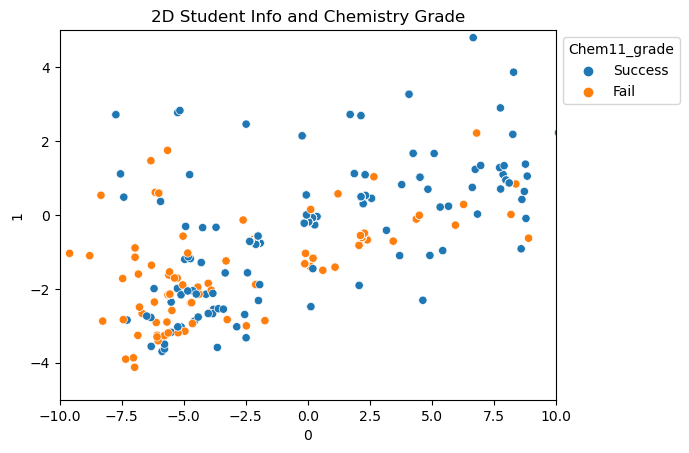

In [41]:
#set up FAMD method
df_ML_PF = df_ML

df_ML_PF['Chem11_grade'] = df_ML_PF['Chem11_grade'].replace(['A', 'B', 'C'], 'Success')
df_ML_PF['Chem11_grade'] = df_ML_PF['Chem11_grade'].replace(['D', 'F'], 'Fail')

df_ML_PF['Chem11_grade'].head()

df_ML_PF = df_ML_PF[df_ML_PF['chem11']>0]

#reset index to id 
df_ML_PF = df_ML_PF.set_index(['ID'])


#extract labels and drop nan
df_ML_PF = df_ML_PF.dropna()
df_ML_PF_labels = df_ML_PF[['chem11', 'chem11_score', 'Chem11_grade']]
df_ML_PF = df_ML_PF.drop(['chem11', 'chem11_score', 'Chem11_grade'], axis = 1)

#set up FAMD method
famd_2D_PF = FAMD(n_components=2,n_iter=3,copy=True,check_input=True,engine='sklearn',random_state=42)

#reduce dimensions for training set
famd_2D_PF =famd_2D_PF.fit(df_ML_train)
df_ML_PF_reduced_2D = famd_2D_PF.row_coordinates(df_ML_train)

#join reduced data with labels
df_ML_PF_reduced_2D_labels = df_ML_PF_reduced_2D.join(df_ML_PF_labels['Chem11_grade']).reset_index()

#plot 2D data
x = df_ML_PF_reduced_2D_labels[0]
y = df_ML_PF_reduced_2D_labels[1]
colors = df_ML_PF_reduced_2D_labels['Chem11_grade']

fig, ax = plt.subplots()
sns.scatterplot(x, y, hue=colors, hue_order = ['Success', 'Fail'])
ax.set(xlim = (-10, 10), ylim = (-5, 5), title = "2D Student Info and Chemistry Grade")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


In [16]:
import re, seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

#set up FAMD method
famd = FAMD(n_components=3,n_iter=3,copy=True,check_input=True,engine='sklearn',random_state=42)
famd2 = FAMD(n_components=3,n_iter=3,copy=True,check_input=True,engine='sklearn',random_state=42)

#reduce dimensions for training set
famd =famd.fit(df_ML_train)
df_ML_train_reduced = famd.row_coordinates(df_ML_train)
df_ML_train_reduced = df_ML_train_reduced
df_ML_train_reduced_labels = df_ML_train_reduced.join(df_ML_labels['Chem11_grade']).reset_index()


famd2 =famd2.fit(df_ML_test)
df_ML_test_reduced = famd2.row_coordinates(df_ML_test)
df_ML_test_reduced = df_ML_test_reduced.reset_index()

# list data
x = df_ML_train_reduced_labels[0]
y = df_ML_train_reduced_labels[1]
z = df_ML_train_reduced_labels[2]
#colors = df_ML_train_reduced_labels['Chem11_grade']

# axes instance
#fig = plt.figure(figsize=(6,6))
#ax = Axes3D(fig, auto_add_to_figure=False)
#fig.add_axes(ax)

# get colormap from seaborn
#cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
#sc = ax.scatter(x, y, z, s=40) #c=colors, 
            #marker='o', cmap=cmap, alpha=1)
#ax.set(xlim = (-10, 16), ylim = (-2.5, 2.5), zlim = (-2.5, 3))

# legend
#plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

C:\Users\Michael\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:797: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if dtype_orig is not None and dtype_orig in dtype:
C:\Users\Michael\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:797: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if dtype_orig is not None and dtype_orig in dtype:


In [11]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

#create list of categorical features
category_features = ['Gender', 'Counselor', 'ELL_Status', 'schoolName']

#use one hot encoder method to create an array of encoded data
ohn_data = pd.DataFrame(ohe.fit_transform(df[category_features]).toarray())

#create a dictionary of the encoded columns with meaningful names
ohn_columns = {0: 'Female', 1: 'Male', 2: 'Counselor10', 3: 'Counselor13', 4: 'Counselor16', 5: 'Counselor16', 6: 'Counselor19',
               7: 'Counselor22', 8: 'Counselor25', 9: 'Counselor28', 10: 'Counselor31', 11: 'Counselor34', 12: 'Counselor37', 
               13: 'Non-ELL', 14: 'ELL'}

#replace the column names with meaningful names
ohn_data = ohn_data.rename(columns=ohn_columns)

#create new df by joining categorical data array with non categorical array 
new_df = df.join(ohn_data)

#drop non encoded categorical data
new_df = new_df.drop(category_features, axis=1)

#drop all missing values 
new_df = new_df.dropna()

#create new idexes
new_df = new_df.set_index('ID')

#new_df.head()

In [12]:
#KNN Supervised ML for predition of which students would enroll in Chem
# Import necessary modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score


# Create feature and target arrays
X = new_df.drop(['chem11', 'chem11_score', 'Chem11_grade'], axis=1)
X = X.values
y = new_df['chem11']
y = y.values

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size = 0.2, random_state=903)
  
knn = KNeighborsClassifier(n_neighbors=3)
  
knn.fit(X_train, y_train)
  
# Predict on dataset which model has not seen before
pred =knn.predict(X_test) 

#print statistics to measure the model's performance 
print("Confusion Matrix: \n", confusion_matrix(y_test, pred))
print("Accuracy Score:", accuracy_score(pred,y_test))
print("Precision:", precision_score(pred, y_test))
print("Recall:", recall_score(pred, y_test))

Confusion Matrix: 
 [[28  5]
 [ 9  1]]
Accuracy Score: 0.6744186046511628
Precision: 0.8484848484848485
Recall: 0.7567567567567568


In [13]:
#Supervised ML to predict students grades
# Create feature and target arrays
X = new_df.drop(['chem11', 'chem11_score', 'Chem11_grade'], axis=1)
X = X.values
y = new_df['Chem11_grade']
y = y.values

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size = 0.2, random_state=903)
  
knn = KNeighborsClassifier(n_neighbors=3)
  
knn.fit(X_train, y_train)
  
# Predict on dataset which model has not seen before
pred =knn.predict(X_test) 

#print statistics to measure the model's performance 
print("Confusion Matrix: \n", confusion_matrix(y_test, pred))
print("Accuracy Score:", accuracy_score(pred,y_test))
#print("Precision:", precision_score(pred, y_test))
#print("Recall:", recall_score(pred, y_test))

Confusion Matrix: 
 [[1 1 0 0 0]
 [1 8 1 0 1]
 [0 3 5 0 0]
 [0 3 3 2 1]
 [0 0 4 2 7]]
Accuracy Score: 0.5348837209302325
